# Cognitive Science
## Parsa Daghigh - HW1

### Imports

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.special import erf
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.stats import pearsonr, spearmanr

In [40]:
df = pd.read_csv('data.csv')

In [41]:
# We do not want mixed samples
same_block = df[df['blockType'] == 'same']

# choosing one subject and trial key
chosen_data = same_block[(same_block['trialKeys'] == 'AbHa') & (same_block['subjectId'] == 'sub1')].copy()
chosen_data['choseHasan'] = chosen_data['srespChoice'] == 'Hasan'

group = chosen_data.groupby('levelFace')['choseHasan'].mean().reset_index()

In [42]:
same_block

,trialKeys,levelFreq,levelFace,lCueName,rCueName,srespLoc,srespChoice,RT,Hand,blockType,subjectId
0,AbHa,LF,1,Hasan,Abbas,right,Abbas,0.672450,Left,same,sub1
1,MahGol,LF,3,Goli,Mahnaz,right,Mahnaz,2.157862,Left,same,sub1
2,AbHa,LF,-3,Hasan,Abbas,right,Abbas,1.110335,Left,same,sub1
3,AbHa,LF,0,Hasan,Abbas,right,Abbas,0.676922,Left,same,sub1
4,MahGol,LF,0,Goli,Mahnaz,right,Mahnaz,0.970347,Left,same,sub1
...,...,...,...,...,...,...,...,...,...,...,...
50395,MahGol,IF,-2,Goli,Mahnaz,right,Mahnaz,0.420876,Right,same,sub38
50396,AbHa,IF,-2,Hasan,Abbas,right,Abbas,0.629925,Right,same,sub38
50397,MahGol,IF,-1,Goli,Mahnaz,right,Mahnaz,1.611287,Right,same,sub38
50398,AbHa,IF,-1,Hasan,Abbas,left,Hasan,0.917896,Right,same,sub38


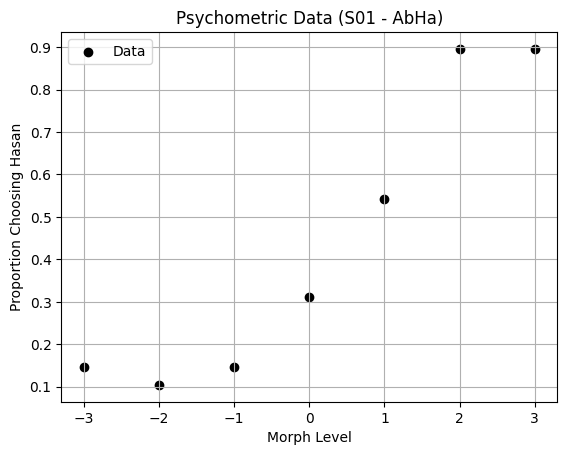

In [43]:
plt.scatter(group["levelFace"], group["choseHasan"], color='black', label="Data")
plt.xlabel("Morph Level")
plt.ylabel("Proportion Choosing Hasan")
plt.title("Psychometric Data (S01 - AbHa)")
plt.grid(True)
plt.legend()
plt.show()

In [44]:
group

,levelFace,choseHasan
0,-3,0.145833
1,-2,0.104167
2,-1,0.145833
3,0,0.312500
4,1,0.541667
5,2,0.895833
6,3,0.895833


In [45]:
def sigmoid(x, beta):
    return 1 / (np.exp(-(beta * x)) + 1)
x_data = group['levelFace']
y_data = group['choseHasan']
popt, pcov = curve_fit(sigmoid, x_data, y_data)
beta = popt[0]

print("Estimated sensitivity (beta):", beta)

Estimated sensitivity (beta): 0.8642531781373323


### Fitting subject 1 with AbHa pair

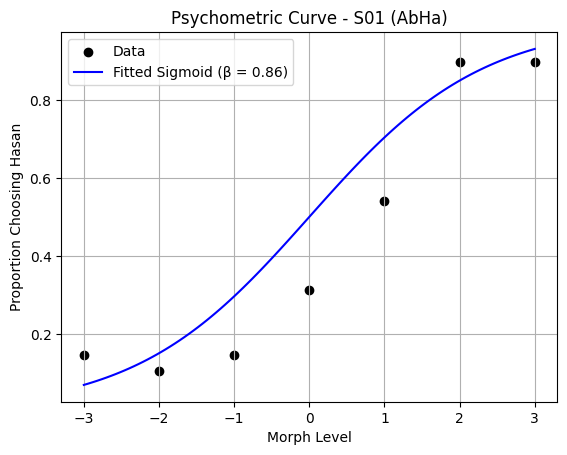

In [46]:
x_fit = np.linspace(-3, 3, 100)
y_fit = sigmoid(x_fit, beta)

plt.scatter(x_data, y_data, label="Data", color="black")
plt.plot(x_fit, y_fit, label=f"Fitted Sigmoid (β = {beta:.2f})", color="blue")
plt.xlabel("Morph Level")
plt.ylabel("Proportion Choosing Hasan")
plt.title("Psychometric Curve - S01 (AbHa)")
plt.legend()
plt.grid(True)
plt.show()

## Hypothesis 1: <br>
## We should collect and analyse all subjects with different frequencies for each pair.

In [47]:
sensitivity_results = []

subjects = same_block["subjectId"].unique()
frequencies = ["IF", "LF", "HF"]
pairs = ["AbHa", "MahGol"]

for subject in subjects:
    for freq in frequencies:
        for pair in pairs:

            subj_data = same_block[
                (same_block["subjectId"] == subject) &
                (same_block["trialKeys"] == pair) &
                (same_block["levelFreq"] == freq)
            ].copy()

            if subj_data.empty:
                continue
            if pair == "AbHa":
                subj_data["choseTarget"] = subj_data["srespChoice"] == "Hasan"
            else:
                subj_data["choseTarget"] = subj_data["srespChoice"] == "Goli"
            grouped = subj_data.groupby("levelFace")["choseTarget"].mean().reset_index()

            x_data = grouped["levelFace"].values
            y_data = grouped["choseTarget"].values

            try:
                popt, _ = curve_fit(sigmoid, x_data, y_data, p0=[1.0])
                beta = popt[0]
            except:
                beta = np.nan  # fitting failed

            sensitivity_results.append({
                "subjectID": subject,
                "frequency": freq,
                "pair": pair,
                "beta": beta
            })

results_df = pd.DataFrame(sensitivity_results)

In [48]:
results_df.head()

,subjectID,frequency,pair,beta
0,sub1,IF,AbHa,1.300046
1,sub1,IF,MahGol,1.614227
2,sub1,LF,AbHa,1.204994
3,sub1,LF,MahGol,0.682989
4,sub1,HF,AbHa,0.367406


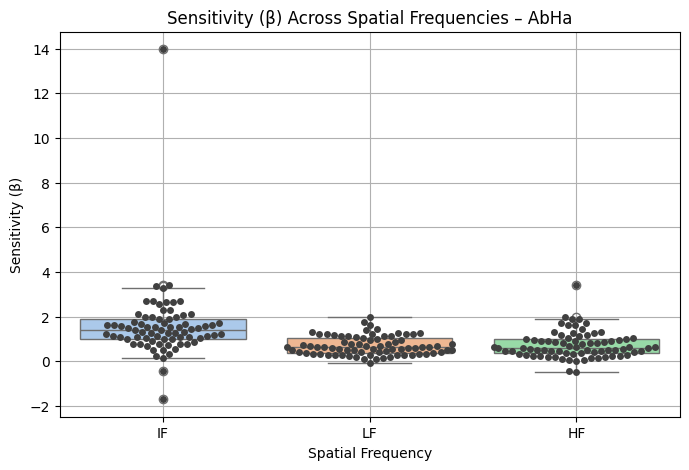

In [49]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=results_df, x="frequency", y="beta", hue="frequency", palette="pastel", legend=False)
sns.swarmplot(data=results_df, x="frequency", y="beta", color=".25")
plt.title("Sensitivity (β) Across Spatial Frequencies – AbHa")
plt.ylabel("Sensitivity (β)")
plt.xlabel("Spatial Frequency")
plt.grid(True)
plt.show()

In [50]:
avg_df = results_df.groupby(["subjectID", "frequency"])["beta"].mean().reset_index()

wide_df = avg_df.pivot(index="subjectID", columns="frequency", values="beta").dropna()

stat, p = friedmanchisquare(wide_df["IF"], wide_df["LF"], wide_df["HF"])
print(f"Friedman test (combined pairs): statistic = {stat:.4f}, p = {p}")


Friedman test (combined pairs): statistic = 43.0000, p = 4.5990553786523223e-10


In [51]:

# Pairwise comparisons
stat_if_lf, p_if_lf = wilcoxon(wide_df["IF"], wide_df["LF"])
stat_if_hf, p_if_hf = wilcoxon(wide_df["IF"], wide_df["HF"])
stat_lf_hf, p_lf_hf = wilcoxon(wide_df["LF"], wide_df["HF"])

print(f"IF vs LF: stat={stat_if_lf:.2f}, p={p_if_lf}")
print(f"IF vs HF: stat={stat_if_hf:.2f}, p={p_if_hf}")
print(f"LF vs HF: stat={stat_lf_hf:.2f}, p={p_lf_hf}")


IF vs LF: stat=23.00, p=4.6566128730773926e-09
IF vs HF: stat=30.00, p=1.4806573744863272e-08
LF vs HF: stat=345.00, p=0.7199871621851344


In [52]:
subject_info = pd.read_csv('subjectInfo.csv')
subject_info['subjectid'] = ['sub' + str(i+1) for i in range(len(subject_info))]

results_df.columns = results_df.columns.str.strip().str.lower()
subject_info.columns = subject_info.columns.str.strip().str.lower()

merged = pd.merge(results_df, subject_info, on="subjectid", how='left')
merged.head()


,subjectid,frequency,pair,beta,age,sex,dom
0,sub1,IF,AbHa,1.300046,25,M,R
1,sub1,IF,MahGol,1.614227,25,M,R
2,sub1,LF,AbHa,1.204994,25,M,R
3,sub1,LF,MahGol,0.682989,25,M,R
4,sub1,HF,AbHa,0.367406,25,M,R


## Hypothesis 5: Who's better? Women or Men?

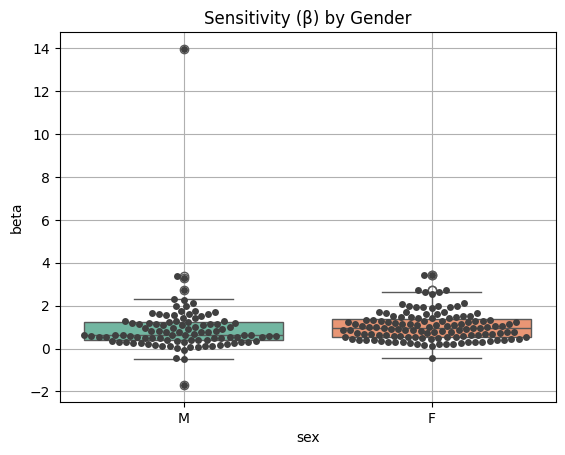

Gender comparison: U = 5303.50, p = 0.0235


In [53]:
merged["sex"] = merged["sex"].str.strip().str.upper()

# Compare overall beta between males and females
male_betas = merged[merged["sex"] == "M"]["beta"]
female_betas = merged[merged["sex"] == "F"]["beta"]

# Plot
sns.boxplot(data=merged, x="sex", y="beta", hue="sex", palette="Set2", legend=False)
sns.swarmplot(data=merged, x="sex", y="beta", color=".25")
plt.title("Sensitivity (β) by Gender")
plt.grid(True)
plt.show()

# Statistical test
stat, p = mannwhitneyu(male_betas, female_betas)
print(f"Gender comparison: U = {stat:.2f}, p = {p:.4f}")


## Hypothesis 2:Same or Opposite gender? Which one am I better at?

In [54]:
merged["face_gender"] = merged["pair"].map({
    "AbHa": "M",
    "MahGol": "F"
})

# Compare "same" vs "opposite" gender
merged["gender_match"] = merged["sex"] == merged["face_gender"]

same_gender = merged[merged["gender_match"] == True]["beta"]
opposite_gender = merged[merged["gender_match"] == False]["beta"]

stat, p = mannwhitneyu(same_gender, opposite_gender)
print(f"Same-gender vs opposite-gender: U = {stat:.2f}, p = {p:.4f}")


Same-gender vs opposite-gender: U = 6144.00, p = 0.4778


In [55]:
# Some cleaning dataframes
subject_info.columns = subject_info.columns.str.strip().str.lower()
subject_info["subjectid"] = ["sub" + str(i + 1) for i in range(len(subject_info))]
df.columns = df.columns.str.strip().str.lower()

# Merge trial-level data with subject info
trial_data = df.merge(subject_info, on="subjectid")


In [56]:
trial_data

,trialkeys,levelfreq,levelface,lcuename,rcuename,sresploc,srespchoice,rt,hand,blocktype,subjectid,age,sex,dom
0,AbHa,LF,1,Hasan,Abbas,right,Abbas,0.672450,Left,same,sub1,25,M,R
1,MahGol,LF,3,Goli,Mahnaz,right,Mahnaz,2.157862,Left,same,sub1,25,M,R
2,AbHa,LF,-3,Hasan,Abbas,right,Abbas,1.110335,Left,same,sub1,25,M,R
3,AbHa,LF,0,Hasan,Abbas,right,Abbas,0.676922,Left,same,sub1,25,M,R
4,MahGol,LF,0,Goli,Mahnaz,right,Mahnaz,0.970347,Left,same,sub1,25,M,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51067,MahGol,LF,-1,Mahnaz,Goli,left,Mahnaz,1.531718,Right,mix,sub38,36,F,R
51068,AbHa,HF,-1,Abbas,Hasan,right,Hasan,0.985676,Right,mix,sub38,36,F,R
51069,AbHa,IF,-2,Abbas,Hasan,left,Abbas,1.299862,Right,mix,sub38,36,F,R
51070,MahGol,IF,-3,Mahnaz,Goli,left,Mahnaz,2.106708,Right,mix,sub38,36,F,R


In [57]:
def fit_sigmoid(x, y):
    def sigmoid(x, beta):
        return 1 / (1 + np.exp(-beta * x))
    try:
        popt, _ = curve_fit(sigmoid, x, y, p0=[1.0])
        return popt[0]  # beta
    except:
        return np.nan


In [58]:
hand_results = []

subjects = trial_data["subjectid"].unique()
frequencies = ["IF", "LF", "HF"]
pairs = ["AbHa", "MahGol"]

for subject in subjects:
    for freq in frequencies:
        for hand in ["Left", "Right"]:
            subset = trial_data[
                (trial_data["subjectid"] == subject) &
                (trial_data["levelfreq"] == freq) &
                (trial_data["blocktype"] == "same") &
                (trial_data["hand"] == hand)
            ].copy()

            if subset.empty:
                continue

            subset["target"] = np.where(subset["trialkeys"] == "AbHa",
                                        subset["srespchoice"] == "Hasan",
                                        subset["srespchoice"] == "Goli")

            grouped = subset.groupby("levelface")["target"].mean().reset_index()
            beta = fit_sigmoid(grouped["levelface"], grouped["target"])

            hand_results.append({
                "subjectid": subject,
                "frequency": freq,
                "hand": hand,
                "beta": beta
            })

hand_df = pd.DataFrame(hand_results)


In [59]:
hand_df.head()

,subjectid,frequency,hand,beta
0,sub1,IF,Left,1.300062
1,sub1,IF,Right,1.614227
2,sub1,LF,Left,0.920021
3,sub1,LF,Right,0.872290
4,sub1,HF,Left,0.561597


In [60]:
dom_results = []

for subject in subjects:
    dom_hand = subject_info[subject_info["subjectid"] == subject]["dom"].values[0].lower()

    for freq in frequencies:
        for hand in ["Left", "Right"]:
            is_dom = (hand == dom_hand)
            subset = trial_data[
                (trial_data["subjectid"] == subject) &
                (trial_data["levelfreq"] == freq) &
                (trial_data["blocktype"] == "same") &
                (trial_data["hand"] == hand)
            ].copy()

            if subset.empty:
                continue

            subset["target"] = np.where(subset["trialkeys"] == "AbHa",
                                        subset["srespchoice"] == "Hasan",
                                        subset["srespchoice"] == "Goli")

            grouped = subset.groupby("levelface")["target"].mean().reset_index()
            beta = fit_sigmoid(grouped["levelface"], grouped["target"])

            dom_results.append({
                "subjectid": subject,
                "frequency": freq,
                "hand": hand,
                "is_dom": is_dom,
                "beta": beta
            })

dom_df = pd.DataFrame(dom_results)


In [61]:
dom_df.head()

,subjectid,frequency,hand,is_dom,beta
0,sub1,IF,Left,False,1.300062
1,sub1,IF,Right,False,1.614227
2,sub1,LF,Left,False,0.920021
3,sub1,LF,Right,False,0.872290
4,sub1,HF,Left,False,0.561597


## Hypothesis 3: Left hand or Right hand? WHO WINS?

In [62]:
# Step 1: average β per subject and hand (across frequencies)
avg_hand = hand_df.groupby(["subjectid", "hand"])["beta"].mean().reset_index()

wide = avg_hand.pivot(index="subjectid", columns="hand", values="beta").dropna()

stat, p = wilcoxon(wide["Left"], wide["Right"])
print(f"Left vs Right Hand: stat = {stat:.2f}, p = {p:.4f}")


Left vs Right Hand: stat = 333.00, p = 0.5955


## Hypothesis 4: Is dominant hand actually dominant?

In [63]:
dom_wide = dom_df.pivot_table(index="subjectid", columns="is_dom", values="beta")

if set(dom_wide.columns) == {0, 1}:
    dom_wide.columns = ["non_dom", "dom"]
    dom_wide = dom_wide.dropna()
    stat, p = wilcoxon(dom_wide["dom"], dom_wide["non_dom"])
    print(f"Dominant vs Non-Dominant: stat = {stat:.2f}, p = {p:.4f}")
else:
    print("Not enough data: One of the groups (dominant or non-dominant) is missing.")


Not enough data: One of the groups (dominant or non-dominant) is missing.


### Which model fits best?

In [64]:
def sigmoid_simple(x, alpha, beta):
    return alpha / (1 + np.exp(-beta * x))

def sigmoid_general(x, alpha, beta, y, lam):
    return alpha / (1 + np.exp(-beta * (x - y))) + lam

def gaussian_cdf(x, mu, sigma):
    return 0.5 * (1 + erf((x - mu) / (sigma * np.sqrt(2))))

In [65]:
# Filter data for one condition:
# Can be set to for example sub1 MahGol HF
data = df[
    (df["subjectid"] == "sub1") &
    (df["trialkeys"] == "MahGol") &
    (df["levelfreq"] == "IF") &
    (df["blocktype"] == "same")
].copy()

# Convert to binary response (chose Hasan)
data["target"] = data["srespchoice"] == "Goli"

# Group by morph level
grouped = data.groupby("levelface")["target"].mean().reset_index()
x = grouped["levelface"].values
y = grouped["target"].values


In [66]:
popt_simple, _ = curve_fit(sigmoid_simple, x, y, p0=[1, 1])
popt_gen, _ = curve_fit(sigmoid_general, x, y, p0=[1, 1, 0, 0])
popt_cdf, _ = curve_fit(gaussian_cdf, x, y, p0=[0, 1])

In [67]:
def calculate_aic_bic(model_func, x, y, popt, k):
    residuals = y - model_func(x, *popt)
    sse = np.sum(residuals ** 2)
    n = len(y)
    aic = n * np.log(sse / n) + 2 * k
    bic = n * np.log(sse / n) + k * np.log(n)
    return aic, bic

aic_simple, bic_simple = calculate_aic_bic(sigmoid_simple, x, y, popt_simple, k=2)
aic_gen, bic_gen = calculate_aic_bic(sigmoid_general, x, y, popt_gen, k=4)
aic_cdf, bic_cdf = calculate_aic_bic(gaussian_cdf, x, y, popt_cdf, k=2)


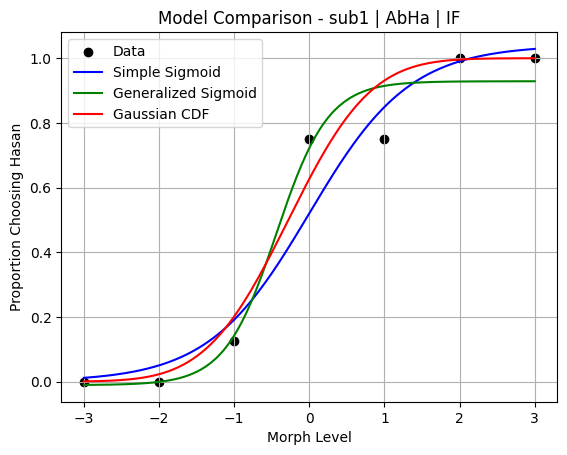

In [68]:
x_fit = np.linspace(-3, 3, 200)
plt.scatter(x, y, label="Data", color="black")

plt.plot(x_fit, sigmoid_simple(x_fit, *popt_simple), label="Simple Sigmoid", color="blue")
plt.plot(x_fit, sigmoid_general(x_fit, *popt_gen), label="Generalized Sigmoid", color="green")
plt.plot(x_fit, gaussian_cdf(x_fit, *popt_cdf), label="Gaussian CDF", color="red")

plt.title("Model Comparison - sub1 | AbHa | IF")
plt.xlabel("Morph Level")
plt.ylabel("Proportion Choosing Hasan")
plt.legend()
plt.grid(True)
plt.show()


In [69]:
comparison = pd.DataFrame({
    "Model": ["Simple Sigmoid", "Generalized Sigmoid", "Gaussian CDF"],
    "AIC": [aic_simple, aic_gen, aic_cdf],
    "BIC": [bic_simple, bic_gen, bic_cdf]
})

print(comparison.sort_values("AIC"))

                 Model        AIC        BIC
2         Gaussian CDF -30.010664 -30.118844
1  Generalized Sigmoid -28.422070 -28.638430
0       Simple Sigmoid -28.175848 -28.284028


# Question 2

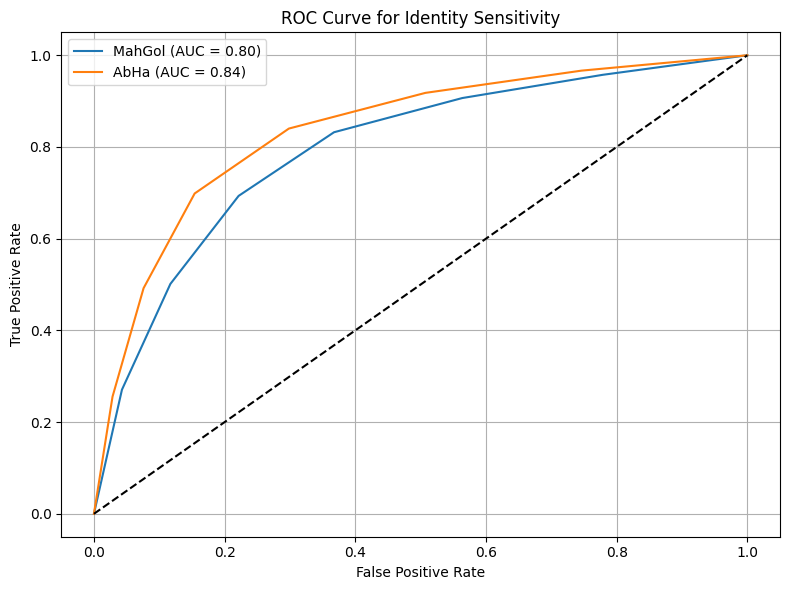

AUC for MahGol: 0.796
AUC for AbHa: 0.837


In [70]:
def compute_sROC(data, correct_name, label):
    data = data.copy()
    data["correct"] = data["srespChoice"] == correct_name
    data["levelFace"] = pd.to_numeric(data["levelFace"], errors="coerce")
    data = data.dropna(subset=["levelFace", "correct"])

    # ROC calculation
    fpr, tpr, _ = roc_curve(data["correct"], data["levelFace"])
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

    return roc_auc

mahgol_data = same_block[same_block["trialKeys"] == "MahGol"]
abha_data = same_block[same_block["trialKeys"] == "AbHa"]

# Plot ROC curves
plt.figure(figsize=(8, 6))

auc_mahgol = compute_sROC(mahgol_data, correct_name="Goli", label="MahGol")
auc_abha = compute_sROC(abha_data, correct_name="Hasan", label="AbHa")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Identity Sensitivity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC for MahGol: {auc_mahgol:.3f}")
print(f"AUC for AbHa: {auc_abha:.3f}")


sROC DataFrame (first few rows):
  subjectId frequency    pair      sroc
0      sub1        IF    AbHa  0.953228
1      sub1        IF  MahGol  0.959770
2      sub1        LF    AbHa  0.908293
3      sub1        LF  MahGol  0.896748
4      sub1        HF    AbHa  0.696352


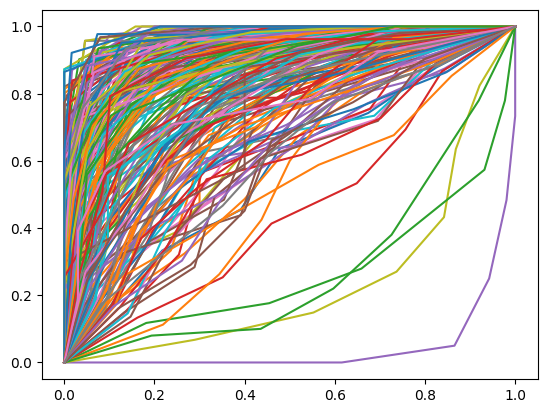

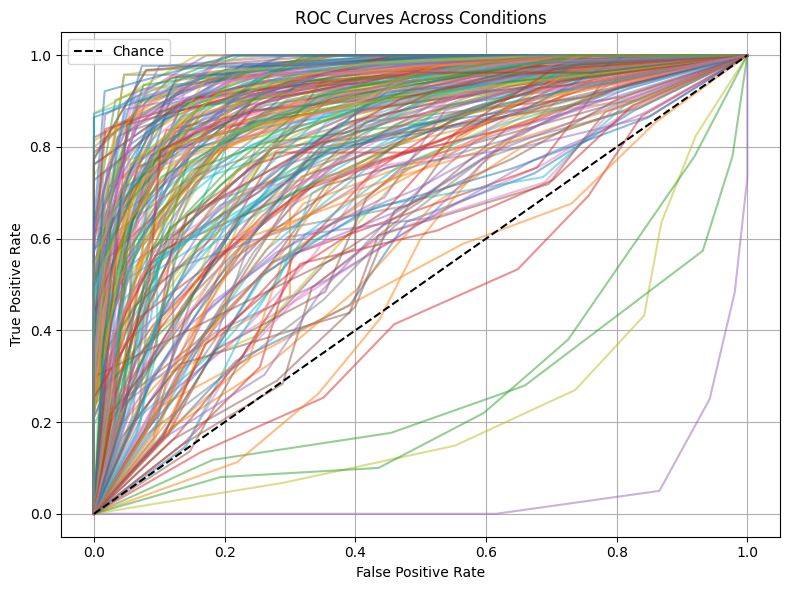

In [71]:
def compute_sROC_raw(data, correct_name, label, flip=False):
    data = data.copy()
    data["correct"] = (data["srespChoice"] == correct_name).astype(int)
    data["levelFace"] = pd.to_numeric(data["levelFace"], errors="coerce")
    if flip:
        data["levelFace"] = -data["levelFace"]
    data = data.dropna(subset=["levelFace", "correct"])

    # Compute ROC curve using levelFace as the decision variable.
    fpr, tpr, _ = roc_curve(data["correct"], data["levelFace"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
    return roc_auc

same_block.loc[:, "subjectId"] = same_block["subjectId"].str.strip().str.lower()
same_block.loc[:, "trialKeys"] = same_block["trialKeys"].str.strip()
same_block.loc[:, "levelFreq"] = same_block["levelFreq"].str.strip().str.upper()
same_block.loc[:, "blockType"] = same_block["blockType"].str.strip().str.lower()
same_block.loc[:, "srespChoice"] = same_block["srespChoice"].str.strip()

sroc_results = []

subjects = same_block["subjectId"].unique()
frequencies = ["IF", "LF", "HF"]
pairs = ["AbHa", "MahGol"]

for subj in subjects:
    for freq in frequencies:
        for pair in pairs:
            # Filter the data for the condition:
            subset = same_block[
                (same_block["subjectId"] == subj) &
                (same_block["trialKeys"] == pair) &
                (same_block["levelFreq"] == freq) &
                (same_block["blockType"] == "same")
            ].copy()
            if subset.empty:
                continue
            if pair == "AbHa":
                sroc_val = compute_sROC_raw(subset, correct_name="Hasan", label=f"{subj}-{freq}-{pair}", flip=False)
            else:
                sroc_val = compute_sROC_raw(subset, correct_name="Mahnaz", label=f"{subj}-{freq}-{pair}", flip=True)
            sroc_results.append({
                "subjectId": subj,
                "frequency": freq,
                "pair": pair,
                "sroc": sroc_val
            })

sroc_df = pd.DataFrame(sroc_results)
print("sROC DataFrame (first few rows):")
print(sroc_df.head())

# Plot ROC curves for all conditions
plt.figure(figsize=(8,6))
for subj in subjects:
    for freq in frequencies:
        for pair in pairs:
            subset = same_block[
                (same_block["subjectId"] == subj) &
                (same_block["trialKeys"] == pair) &
                (same_block["levelFreq"] == freq) &
                (same_block["blockType"] == "same")
            ]
            if subset.empty:
                continue
            # Determine if we need to flip for MahGol.
            flip = True if pair == "MahGol" else False
            # Compute ROC curve components (without computing sROC again).
            temp = subset.copy()
            temp["correct"] = (temp["srespChoice"] == ("Mahnaz" if pair=="MahGol" else "Hasan")).astype(int)
            temp["levelFace"] = pd.to_numeric(temp["levelFace"], errors="coerce")
            if flip:
                temp["levelFace"] = -temp["levelFace"]
            temp = temp.dropna(subset=["levelFace", "correct"])
            fpr, tpr, _ = roc_curve(temp["correct"], temp["levelFace"])
            plt.plot(fpr, tpr, alpha=0.5)

plt.plot([0,1],[0,1],"k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Across Conditions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Hypothesis 1

In [72]:
avg_sroc = sroc_df.groupby(["subjectId", "frequency"])["sroc"].mean().reset_index()
wide_sroc = avg_sroc.pivot(index="subjectId", columns="frequency", values="sroc")

print("Available frequency columns:", wide_sroc.columns.tolist())
print("Number of subjects with complete frequency data:", wide_sroc.shape[0])

if {"IF", "LF", "HF"}.issubset(set(wide_sroc.columns)):
    from scipy.stats import friedmanchisquare
    stat, p = friedmanchisquare(wide_sroc["IF"], wide_sroc["LF"], wide_sroc["HF"])
    print(f"Friedman test for sROC across frequencies: stat = {stat:.4f}, p = {p}")
else:
    print("Not all frequency conditions are available for each subject; check your data.")


Available frequency columns: ['HF', 'IF', 'LF']
Number of subjects with complete frequency data: 38
Friedman test for sROC across frequencies: stat = 46.1053, p = 9.735747726976071e-11


## Hypothesis 2

In [73]:
sroc_df["face_gender"] = sroc_df["pair"].map({"AbHa": "M", "MahGol": "F"})
sroc_df["subjectId"] = sroc_df["subjectId"].str.lower()
subject_info["subjectid"] = subject_info["subjectid"].str.lower()
subject_info.rename(columns={'subjectid': 'subjectId'}, inplace=True)
merged_sroc = sroc_df.merge(subject_info, on="subjectId", how="left")
merged_sroc["sex"] = merged_sroc["sex"].str.strip().str.upper()
merged_sroc["gender_match"] = merged_sroc["sex"] == merged_sroc["face_gender"]
avg_gender = merged_sroc.groupby(["subjectId", "gender_match"])["sroc"].mean().reset_index()
wide_gender = avg_gender.pivot(index="subjectId", columns="gender_match", values="sroc").dropna()

print("Subjects with both match and non-match sROC:", wide_gender.shape[0])
if {"True", "False"}.issubset([str(c) for c in wide_gender.columns]):
    from scipy.stats import wilcoxon
    stat, p = wilcoxon(wide_gender[True], wide_gender[False])
    print(f"Wilcoxon test for same- vs. opposite-gender sROC: stat = {stat:.4f}, p = {p:.4f}")
else:
    if {True, False}.issubset(set(wide_gender.columns)):
        stat, p = wilcoxon(wide_gender[True], wide_gender[False])
        print(f"Wilcoxon test for same- vs. opposite-gender sROC: stat = {stat:.4f}, p = {p:.4f}")
    else:
        print("Not enough data for gender comparison.")


Subjects with both match and non-match sROC: 38
Wilcoxon test for same- vs. opposite-gender sROC: stat = 343.0000, p = 0.6986


## Hypothesis 3

In [74]:
def compute_sROC_raw_hand(data, correct_name, flip=False):
    data = data.copy()
    data["correct"] = (data["srespChoice"] == correct_name).astype(int)
    data["levelFace"] = pd.to_numeric(data["levelFace"], errors="coerce")
    if flip:
        data["levelFace"] = -data["levelFace"]
    data = data.dropna(subset=["levelFace", "correct"])
    fpr, tpr, _ = roc_curve(data["correct"], data["levelFace"])
    roc_auc = auc(fpr, tpr)
    return roc_auc

same_block.loc[:, "subjectId"] = same_block["subjectId"].str.strip().str.lower()
same_block.loc[:, "trialKeys"] = same_block["trialKeys"].str.strip()
same_block.loc[:, "levelFreq"] = same_block["levelFreq"].str.strip().str.upper()
same_block.loc[:, "blockType"] = same_block["blockType"].str.strip().str.lower()
same_block.loc[:, "srespChoice"] = same_block["srespChoice"].str.strip()
same_block.loc[:, "Hand"] = same_block["Hand"].str.strip().str.lower()  # Ensure hand is lowercase

sroc_hand_results = []

subjects = same_block["subjectId"].unique()
frequencies = ["IF", "LF", "HF"]
pairs = ["AbHa", "MahGol"]
hands = ["left", "right"]

for subj in subjects:
    for freq in frequencies:
        for pair in pairs:
            for hand in hands:
                # Filter for the specific condition and only the "same" block type.
                subset = same_block[
                    (same_block["subjectId"] == subj) &
                    (same_block["trialKeys"] == pair) &
                    (same_block["levelFreq"] == freq) &
                    (same_block["blockType"] == "same") &
                    (same_block["Hand"] == hand)
                ].copy()

                if subset.empty:
                    continue

                if pair == "AbHa":
                    sroc_val = compute_sROC_raw_hand(subset, correct_name="Hasan", flip=False)
                else:
                    sroc_val = compute_sROC_raw_hand(subset, correct_name="Mahnaz", flip=True)

                sroc_hand_results.append({
                    "subjectid": subj,
                    "frequency": freq,
                    "pair": pair,
                    "hand": hand,
                    "sroc": sroc_val
                })

sroc_hand_df = pd.DataFrame(sroc_hand_results)
print("sroc_hand_df (first few rows):")
print(sroc_hand_df.head())


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


sroc_hand_df (first few rows):
  subjectid frequency    pair   hand      sroc
0      sub1        IF    AbHa   left  0.944444
1      sub1        IF    AbHa  right  0.971795
2      sub1        IF  MahGol   left  0.974839
3      sub1        IF  MahGol  right  0.949553
4      sub1        LF    AbHa   left  0.923226


In [75]:
avg_hand = sroc_hand_df.groupby(["subjectid", "hand"])["sroc"].mean().reset_index()
wide_hand = avg_hand.pivot(index="subjectid", columns="hand", values="sroc").dropna()

print("Subjects with both left and right hand data:", wide_hand.shape[0])
from scipy.stats import wilcoxon
stat, p = wilcoxon(wide_hand["left"], wide_hand["right"])
print(f"Wilcoxon test for left vs. right hand sROC: stat = {stat:.4f}, p = {p:.4f}")


Subjects with both left and right hand data: 38
Wilcoxon test for left vs. right hand sROC: stat = 369.0000, p = 0.9886


## Hypothesis 4

In [76]:
sroc_hand_df["subjectid"] = sroc_hand_df["subjectid"].str.lower()
subject_info["subjectId"] = subject_info["subjectId"].str.lower()
subject_info["dom"] = subject_info["dom"].str.strip().str.upper()
sroc_hand_df.rename(columns={'subjectid': 'subjectId'}, inplace=True)
merged_hand = sroc_hand_df.merge(subject_info, on="subjectId", how="left")

merged_hand["is_dom"] = (merged_hand["hand"].str.lower() == merged_hand["dom"].str.lower())

# Average sROC by subject and is_dom
avg_dom = merged_hand.groupby(["subjectId", "is_dom"])["sroc"].mean().reset_index()
wide_dom = avg_dom.pivot(index="subjectId", columns="is_dom", values="sroc").dropna()

print("Columns in dominant hand comparison:", wide_dom.columns.tolist())

if {True, False}.issubset(set(wide_dom.columns)):
    stat, p = wilcoxon(wide_dom[True], wide_dom[False])
    print(f"Wilcoxon test for dominant vs. non-dominant hand sROC: stat = {stat:.4f}, p = {p:.4f}")
else:
    print("Not enough data for dominant hand comparison.")


Columns in dominant hand comparison: [False]
Not enough data for dominant hand comparison.


## Hypothesis 5

In [77]:
# Average overall sROC by subject (across all conditions)
overall_sroc = sroc_df.groupby("subjectId")["sroc"].mean().reset_index()

overall = overall_sroc.merge(subject_info, on="subjectId", how="left")
overall["sex"] = overall["sex"].str.strip().str.upper()

male_sroc = overall[overall["sex"] == "M"]["sroc"]
female_sroc = overall[overall["sex"] == "F"]["sroc"]

stat, p = mannwhitneyu(male_sroc, female_sroc)
print(f"Mann-Whitney U test for gender differences in overall sROC: stat = {stat:.4f}, p = {p:.4f}")


Mann-Whitney U test for gender differences in overall sROC: stat = 112.0000, p = 0.0527


# Question 3

### We analyse the effect of age

Overall sensitivity (sROC) per subject:
  subjectId      sroc
0      sub1  0.866823
1     sub10  0.731022
2     sub11  0.792031
3     sub12  0.805678
4     sub13  0.762326
Merged sensitivity and subject info:
  subjectId      sroc  age sex dom subjectid
0      sub1  0.866823   25   M   R      sub1
1     sub10  0.731022   23   F   R     sub10
2     sub11  0.792031   31   M   R     sub11
3     sub12  0.805678   25   M   R     sub12
4     sub13  0.762326   23   M   R     sub13


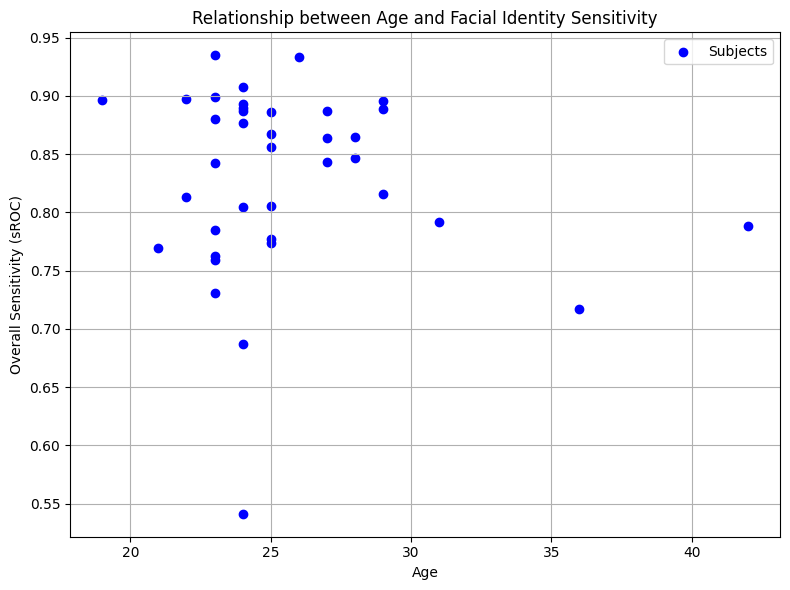

Pearson correlation: r = -0.112, p = 0.504
Spearman correlation: rho = -0.041, p = 0.807


In [78]:
overall_sensitivity_df = sroc_df.groupby("subjectId", as_index=False)["sroc"].mean()

print("Overall sensitivity (sROC) per subject:")
print(overall_sensitivity_df.head())

subject_info["subjectid"] = subject_info["subjectId"].str.strip().str.lower()

merged_df = overall_sensitivity_df.merge(subject_info, on="subjectId", how="left")
print("Merged sensitivity and subject info:")
print(merged_df.head())


plt.figure(figsize=(8,6))
plt.scatter(merged_df["age"], merged_df["sroc"], color="blue", label="Subjects")
plt.xlabel("Age")
plt.ylabel("Overall Sensitivity (sROC)")
plt.title("Relationship between Age and Facial Identity Sensitivity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Compute Pearson correlation between age and sROC
r, p = pearsonr(merged_df["age"], merged_df["sroc"])
print(f"Pearson correlation: r = {r:.3f}, p = {p:.3f}")

# Compute Spearman correlation as an alternative:
rho, p_spearman = spearmanr(merged_df["age"], merged_df["sroc"])
print(f"Spearman correlation: rho = {rho:.3f}, p = {p_spearman:.3f}")
